In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models,layers
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.metrics import classification_report
import itertools

In [2]:
df = pd.read_csv('../input/isic-2019-challenge/ISIC_2019_Training_GroundTruth.csv')
df_train = pd.read_csv('../input/pastas-de-dados/df_train.csv')
df_val = pd.read_csv('../input/pastas-de-dados/df_val.csv')
df_test = pd.read_csv('../input/pastas-de-dados/df_test.csv')

base_dir = '../input/isic-2019-challenge/ISIC_2019_Training_Input/ISIC_2019_Training_Input'

In [3]:
df_train.drop(df_train.loc[df_train['MEL']==1.0].index,inplace=True)
df_train.drop(df_train.loc[df_train['BCC']==1.0].index,inplace=True)
df_train.drop(df_train.loc[df_train['VASC']==1.0].index,inplace=True)
df_train.drop(df_train.loc[df_train['SCC']==1.0].index,inplace=True)
df_train.drop(['MEL','BCC','VASC','SCC'],axis=1,inplace=True)

In [4]:
df_val.drop(df_val.loc[df_val['MEL']==1.0].index,inplace=True)
df_val.drop(df_val.loc[df_val['BCC']==1.0].index,inplace=True)
df_val.drop(df_val.loc[df_val['VASC']==1.0].index,inplace=True)
df_val.drop(df_val.loc[df_val['SCC']==1.0].index,inplace=True)
df_val.drop(['MEL','BCC','VASC','SCC'],axis=1,inplace=True)

In [5]:
df_test.drop(df_test.loc[df_test['MEL']==1.0].index,inplace=True)
df_test.drop(df_test.loc[df_test['BCC']==1.0].index,inplace=True)
df_test.drop(df_test.loc[df_test['VASC']==1.0].index,inplace=True)
df_test.drop(df_test.loc[df_test['SCC']==1.0].index,inplace=True)
df_test.drop(['MEL','BCC','VASC','SCC'],axis=1,inplace=True)

In [6]:
tf.random.set_seed(42)
ia.seed(42)

rand_aug = iaa.RandAugment(n=1, m=2)

def augment(image):
    image = tf.cast(image, tf.uint8)
    return rand_aug(image=image.numpy())

def random_crop(image,aspect_ratio_range=[0.75, 1.33],area_range=[0.08, 1],min_object_covered=0.5,max_attempts=100,seed=0):
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
    tf.shape(image),
    bounding_boxes=bbox,
    min_object_covered=min_object_covered,
    area_range=area_range,
    aspect_ratio_range=aspect_ratio_range,
    use_image_if_no_bounding_boxes=True,
    max_attempts=max_attempts,
    seed=seed)
    offset_height, offset_width, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.crop_to_bounding_box(image,offset_height,offset_width,target_height,target_width)

    return image

In [7]:
def loadImage(image,nv,ak,bkl,df):
 image = tf.io.read_file(base_dir + '/' + image + '.jpg')
 image = tf.io.decode_jpeg(image,channels=3)
 

 label = tf.stack([nv,ak,bkl,df])
 return image,label


def dataAument(image,label):
 image = random_crop(image)
 image = tf.image.convert_image_dtype(image, dtype=tf.float32)
 image = tf.image.resize(image,size = (260,260)) #EfficientNetB2
 image = tf.image.random_flip_left_right(image)
 image = tf.image.random_flip_up_down(image)
 image_shape = tf.shape(image)
 image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
 image2 = tf.py_function(augment,[image],[tf.float32])[0]
 image = tf.ensure_shape(image2,shape=image.get_shape())

 return image,label
 
def resize(image,label):
    image = tf.image.resize(image,size = (260,260)) #EfficientNetB0

    return image,label

In [8]:
len(df_train)

13321

In [9]:
dataSet_train = tf.data.Dataset.from_tensor_slices((df_train['image'],
                                                    df_train['NV'],
                                                    df_train['AK'],
                                                    df_train['BKL'],
                                                    df_train['DF']))
dataSet_train = dataSet_train.shuffle(len(df_train))
dataSet_train = dataSet_train.map(loadImage)
dataSet_train = dataSet_train.map(dataAument)

dataSet_train = dataSet_train.batch(16)

2022-02-17 02:45:59.560086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 02:45:59.665265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 02:45:59.666028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 02:45:59.668295: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
dataSet_val = tf.data.Dataset.from_tensor_slices((df_val['image'],
                                                    df_val['NV'],
                                                    df_val['AK'],
                                                    df_val['BKL'],
                                                    df_val['DF']))
dataSet_val = dataSet_val.map(loadImage)
dataSet_val = dataSet_val.map(resize)
dataSet_val = dataSet_val.batch(16)

In [11]:
dataSet_test = tf.data.Dataset.from_tensor_slices((df_test['image'],
                                                    df_test['NV'],
                                                    df_test['AK'],
                                                    df_test['BKL'],
                                                    df_test['DF']))
dataSet_test = dataSet_test.map(loadImage)
dataSet_test = dataSet_test.map(resize)
dataSet_test = dataSet_test.batch(16)

2022-02-17 02:46:02.347283: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(16, 260, 260, 3)


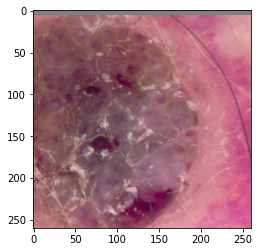

In [12]:
for sample in dataSet_train.take(1):
  print(sample[0].shape)
  plt.imshow(sample[0][0]/255)
  plt.show()

In [13]:
conv_base = EfficientNetB2(include_top=False,weights='imagenet',input_shape=(260,260,3))

conv_base.summary()

31801344/31790344 [==============================] - 1s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 260, 260, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 260, 260, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 261, 261, 3)  0           normalization[0][0]              
____________________

In [14]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 9, 9, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5636      
Total params: 7,774,205
Trainable params: 7,706,630
Non-trainable params: 67,575
_________________________________________________________________


In [15]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["acc"])

H = model.fit(dataSet_train,epochs=40,validation_data = dataSet_val)

Epoch 1/40


2022-02-17 02:46:20.365169: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


833/833 [==============================] - 501s 581ms/step - loss: 0.5014 - acc: 0.8086 - val_loss: 0.4609 - val_acc: 0.8313
Epoch 2/40
833/833 [==============================] - 462s 555ms/step - loss: 0.4319 - acc: 0.8331 - val_loss: 0.3596 - val_acc: 0.8563
Epoch 3/40
833/833 [==============================] - 449s 539ms/step - loss: 0.4041 - acc: 0.8428 - val_loss: 0.4437 - val_acc: 0.8392
Epoch 4/40
833/833 [==============================] - 442s 531ms/step - loss: 0.3807 - acc: 0.8559 - val_loss: 0.4090 - val_acc: 0.8569
Epoch 5/40
833/833 [==============================] - 442s 531ms/step - loss: 0.3611 - acc: 0.8598 - val_loss: 0.3808 - val_acc: 0.8599
Epoch 6/40
833/833 [==============================] - 455s 546ms/step - loss: 0.3503 - acc: 0.8649 - val_loss: 0.3180 - val_acc: 0.8703
Epoch 7/40
833/833 [==============================] - 452s 542ms/step - loss: 0.3359 - acc: 0.8733 - val_loss: 0.2790 - val_acc: 0.8983
Epoch 8/40
833/833 [==============================] - 444s 

In [16]:
#Save the entire model to a HDF5 file.
#The '.h5' extension indicates that the model should be saved to HDF5.
model.save('Class_BENB2.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [17]:
results = model.evaluate(dataSet_test)
print("test loss, test acc:", results)

103/103 [==============================] - 18s 171ms/step - loss: 0.2848 - acc: 0.9123
test loss, test acc: [0.2847751975059509, 0.9123020768165588]


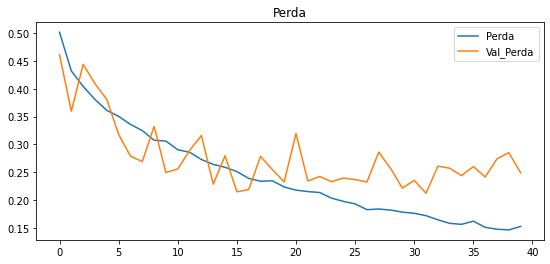

In [18]:
def print_curva(H):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,2)
    plt.plot(H.history['loss'], label='Perda')
    plt.plot(H.history['val_loss'], label='Val_Perda')
    plt.legend()
    plt.title('Perda')
    plt.show()

    
print_curva(H)

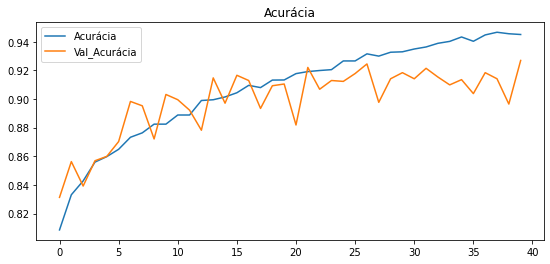

In [19]:
def print_curva2(H):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,2)
    plt.plot(H.history['acc'], label='Acurácia')
    plt.plot(H.history['val_acc'], label='Val_Acurácia')
    plt.legend()
    plt.title('Acurácia')
    plt.show()


print_curva2(H)

In [20]:
df_true = pd.DataFrame([x for x in np.where(df_test == 1, df_test.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))
true_labels = []
for i in df_true['dx']:
  true_labels.append(i)

n = 0 
for i in true_labels:
  if i == 'NV':
    true_labels[n] = 1
  if i == 'AK':
    true_labels[n] = 2
  if i == 'BKL':
    true_labels[n] = 3
  if i == 'DF':
    true_labels[n] = 4
  n += 1

In [21]:
predictions = tf.math.argmax(model.predict(dataSet_test),axis=1)
conf_matrix = tf.math.confusion_matrix(labels=true_labels,predictions=predictions)

In [22]:
array = conf_matrix.numpy()
vet_labels = ['NV','AK','BKL','DF']

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Matriz de Confusão',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo preditado')
    plt.show()

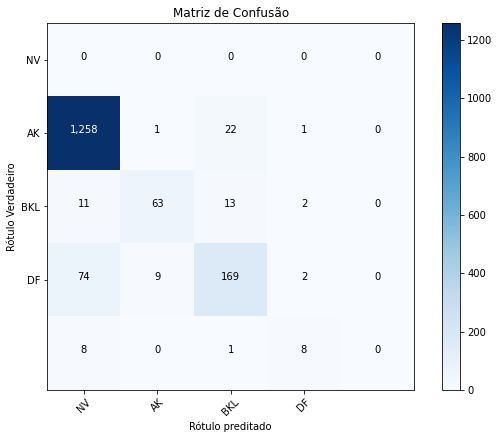

In [24]:
plot_confusion_matrix(array,normalize = False,target_names = vet_labels,title= "Matriz de Confusão")

### print(classification_report(true_labels,predictions,target_names=vet_labels))